In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

In [2]:
walmart_colors = ["#0071CE", "#FFC220", "#FFFFFF"]  # Blue, Yellow, White

In [3]:
%reload_ext autoreload
%autoreload 2

In [4]:
from forecast_forge.data_loader import load_data

In [5]:
df_train, df_test, df_features, df_stores = load_data()

In [7]:
df_features.isnull().sum()

Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140
CPI              585
Unemployment     585
IsHoliday          0
dtype: int64

## TRAIN DATA

In [55]:
# lower_case all columns
df_train.columns = df_train.columns.str.lower()
df_test.columns = df_test.columns.str.lower()

df_train["date"] = pd.to_datetime(df_train["date"])
df_test["date"] = pd.to_datetime(df_test["date"])

In [56]:
# set index as store, dept, date
df_train.set_index(["store", "dept", "date"], inplace=True)
df_test.set_index(["store", "dept", "date"], inplace=True)

In [59]:
df_test

isholiday
store dept date                 
1     1    2012-11-02      False
           2012-11-09      False
           2012-11-16      False
           2012-11-23       True
           2012-11-30      False
...                          ...
45    98   2013-06-28      False
           2013-07-05      False
           2013-07-12      False
           2013-07-19      False
           2013-07-26      False

[115064 rows x 1 columns]

In [60]:
# select random store and dept
store = np.random.choice(df_train.index.get_level_values("store").unique())
dept = np.random.choice(df_train.index.get_level_values("dept").unique())

In [61]:
# check how many dates for each store, dept does tge test set have
df_test.groupby(["store", "dept"]).size()

store  dept
1      1       39
       2       39
       3       39
       4       39
       5       39
               ..
45     93      39
       94      39
       95      39
       97      39
       98      39
Length: 3169, dtype: int64

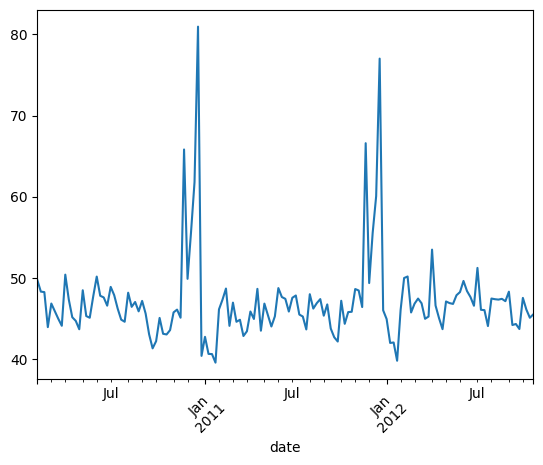

In [25]:
# total sales plot
df_total_sales = df_train.groupby("date")["weekly_sales"].sum() / 1_000_000
df_total_sales.plot()

# 45 degree axis tick labels
plt.xticks(rotation=45)
plt.show()

In [26]:
# total stores
print("Total stores: ", store)
print("Total departments: ", dept)

# total combinations without considering date
print(
    "Total combinations without considering date: ",
    df_train.reset_index().groupby(["store", "dept"]).ngroups,
)

Total stores:  34
Total departments:  54
Total combinations without considering date:  3331


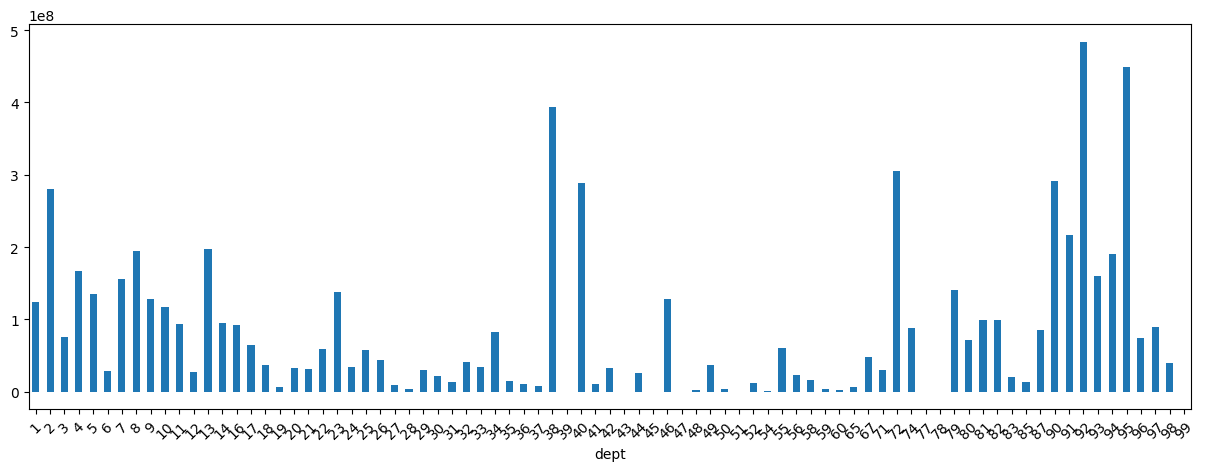

In [27]:
# plot sales by department
from matplotlib import axes


df_sales_by_dept = df_train.groupby("dept")["weekly_sales"].sum()

fig, axes = plt.subplots(figsize=(15, 5))
df_sales_by_dept.plot(kind="bar", ax=axes)

# 45 degree rotation
axes.set_xticklabels(axes.get_xticklabels(), rotation=45)

plt.show()

In [28]:
df_sales_by_dept = df_train.groupby("dept")["weekly_sales"].sum()


df_sales_by_dept = df_sales_by_dept.reset_index(name="sales").sort_values(
    "sales", ascending=False
)
df_sales_by_dept["sales"] = df_sales_by_dept["sales"] / 1_000_000

df_sales_by_dept["cum_sales"] = df_sales_by_dept["sales"].cumsum()

df_sales_by_dept["cum_sales_perc"] = (
    df_sales_by_dept["cum_sales"] / df_sales_by_dept["sales"].sum()
)

df_sales_by_dept["dept"] = df_sales_by_dept["dept"].astype(str)

df_sales_by_dept.set_index("dept", inplace=True)

df_sales_by_dept

,sales,cum_sales,cum_sales_perc
dept,,,
92,483.943342,483.943342,0.071831
95,449.320163,933.263504,0.138524
38,393.118137,1326.381641,0.196874
72,305.725152,1632.106794,0.242252
90,291.068464,1923.175257,0.285455
...,...,...,...
51,0.030573,6737.222043,1.000000
78,0.001715,6737.223758,1.000001
39,0.000178,6737.223936,1.000001


C:\Users\Administrator\AppData\Local\Temp\ipykernel_4768\585330692.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


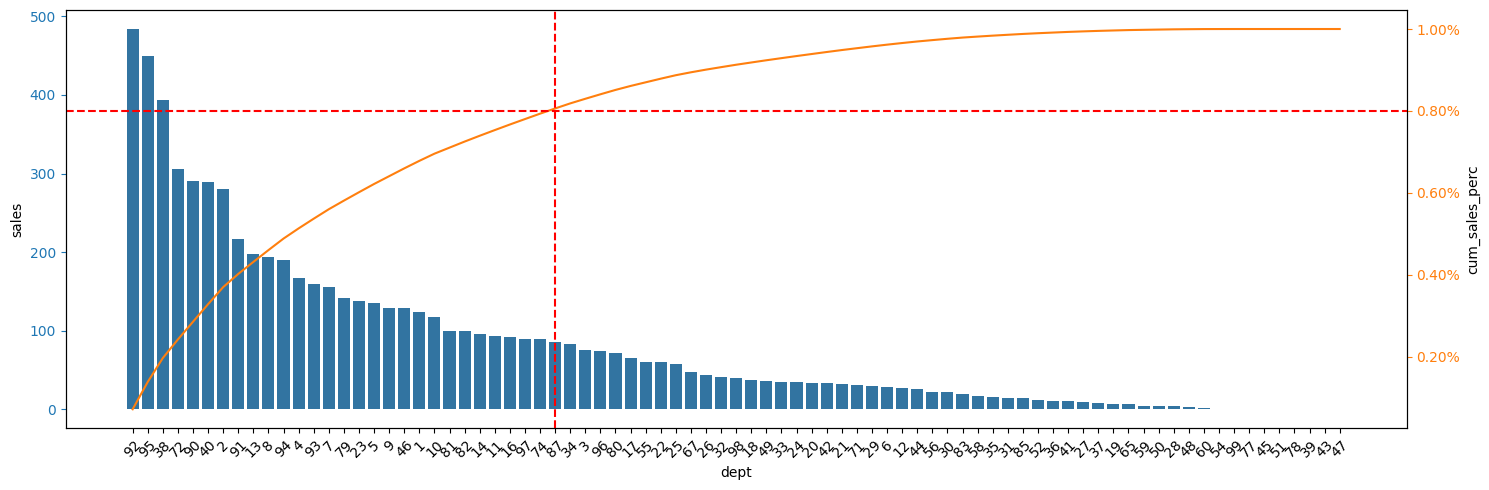

In [29]:
from turtle import color
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter


fig, ax = plt.subplots(figsize=(15, 5))

sns.barplot(x=df_sales_by_dept.index, y="sales", data=df_sales_by_dept, ax=ax)

ax2 = ax.twinx()
sns.lineplot(
    x=df_sales_by_dept.index,
    y="cum_sales_perc",
    data=df_sales_by_dept,
    ax=ax2,
    color="C1",
)

ax2.yaxis.set_major_formatter(PercentFormatter())

ax.tick_params(axis="y", colors="C0")
ax2.tick_params(axis="y", colors="C1")

# 45 degree rotation
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# mark the 80% line
ax2.axhline(0.8, color="red", linestyle="--")

# mark 20% of the departments
n_depts_80 = df_sales_by_dept[df_sales_by_dept["cum_sales_perc"] < 0.8].shape[0]
ax2.axvline(n_depts_80, color="red", linestyle="--")

plt.tight_layout()
plt.show()

<Axes: ylabel='Frequency'>

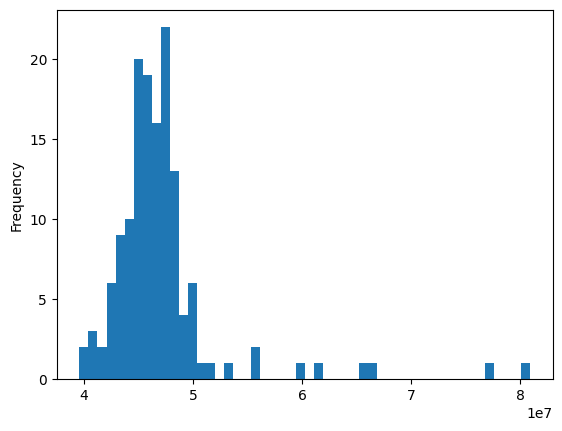

In [30]:
# weekly sales distribution

df_sales = df_train.groupby("date")["weekly_sales"].sum()
df_sales.plot(kind="hist", bins=50)

<Axes: ylabel='Frequency'>

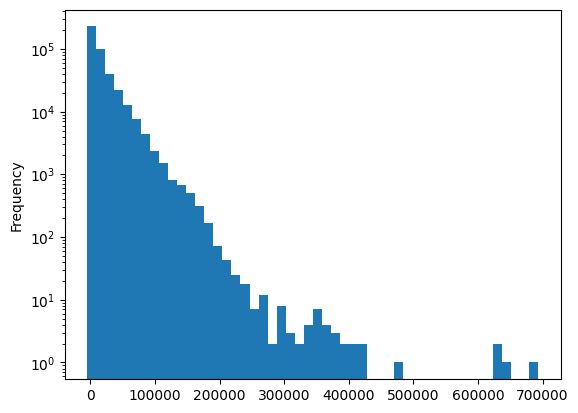

In [31]:
# weekly sales distribution by store-dept-date
df_sales = df_train.groupby(["store", "dept", "date"])["weekly_sales"].sum()

df_sales.plot(kind="hist", bins=50, logy=True)

<Axes: xlabel='week', ylabel='weekly_sales'>

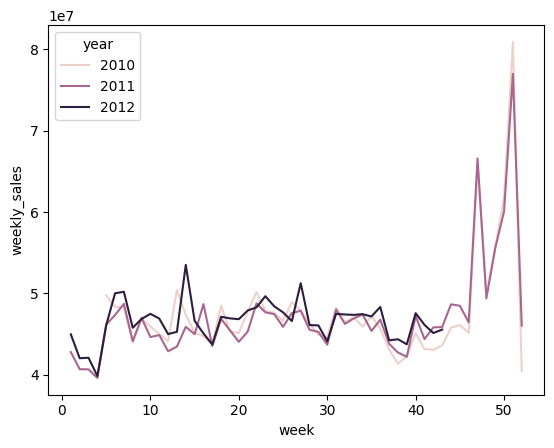

In [32]:
# groupby year
df_sales = df_train.groupby("date")["weekly_sales"].sum()
df_sales.index = pd.to_datetime(df_sales.index)

df_sales = df_sales.reset_index()

df_sales["year"] = df_sales["date"].dt.year
df_sales["week"] = df_sales["date"].dt.isocalendar().week


# plot sales by year
sns.lineplot(x="week", y="weekly_sales", hue="year", data=df_sales)

In [33]:
# perform similar time series analysis for store-dept top 10 in terms of sales
df_sales = df_train.groupby(["store", "dept", "date"])["weekly_sales"].sum()

df_sales = df_sales.reset_index()

df_sales

,store,dept,date,weekly_sales
0,1,1,2010-02-05,24924.50
1,1,1,2010-02-12,46039.49
2,1,1,2010-02-19,41595.55
3,1,1,2010-02-26,19403.54
4,1,1,2010-03-05,21827.90
...,...,...,...,...
421565,45,98,2012-09-28,508.37
421566,45,98,2012-10-05,628.10
421567,45,98,2012-10-12,1061.02
421568,45,98,2012-10-19,760.01


In [43]:
# set store as str
df_sales["store"] = df_sales["store"].astype(str)

<Axes: xlabel='date', ylabel='weekly_sales'>

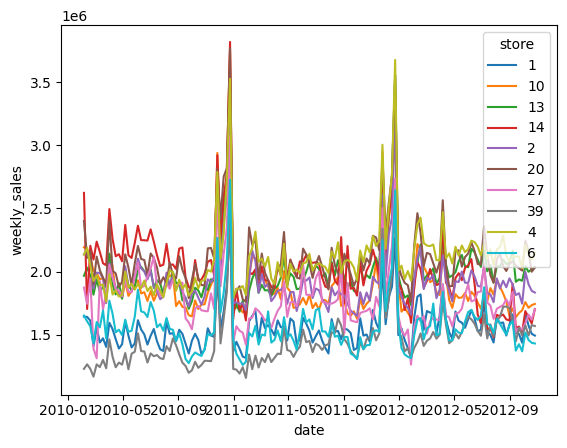

In [44]:
df_sales["year"] = df_sales["date"].dt.year
df_sales["week"] = df_sales["date"].dt.isocalendar().week


# get top performing stores
df_sales_by_store = df_sales.groupby(["store"])["weekly_sales"].sum()

top_stores = df_sales_by_store.sort_values(ascending=False).head(10).index

df_sales_top_stores = df_sales[df_sales["store"].isin(top_stores)]


# total sales by store
df_sales_by_store = df_sales_top_stores.groupby(["store", "date"])["weekly_sales"].sum()

df_sales_by_store = df_sales_by_store.reset_index()


sns.lineplot(x="date", y="weekly_sales", hue="store", data=df_sales_by_store)

store,1,10,13,14,2,20,27,39,4,6
store,,,,,,,,,,
1,1.000000,0.826070,0.875301,0.656309,0.889708,0.911740,0.644600,0.802720,0.894510,0.838850
10,0.826070,1.000000,0.879176,0.802604,0.942706,0.898726,0.741174,0.720862,0.838162,0.870100
13,0.875301,0.879176,1.000000,0.719435,0.917177,0.922354,0.790562,0.909936,0.925791,0.901956
14,0.656309,0.802604,0.719435,1.000000,0.805537,0.775626,0.824622,0.502590,0.570467,0.785510
2,0.889708,0.942706,0.917177,0.805537,1.000000,0.934524,0.787296,0.757612,0.848827,0.914034
20,0.911740,0.898726,0.922354,0.775626,0.934524,1.000000,0.758074,0.799982,0.890174,0.879797
27,0.644600,0.741174,0.790562,0.824622,0.787296,0.758074,1.000000,0.672858,0.606160,0.855077
39,0.802720,0.720862,0.909936,0.502590,0.757612,0.799982,0.672858,1.000000,0.891812,0.799545
4,0.894510,0.838162,0.925791,0.570467,0.848827,0.890174,0.606160,0.891812,1.000000,0.786679


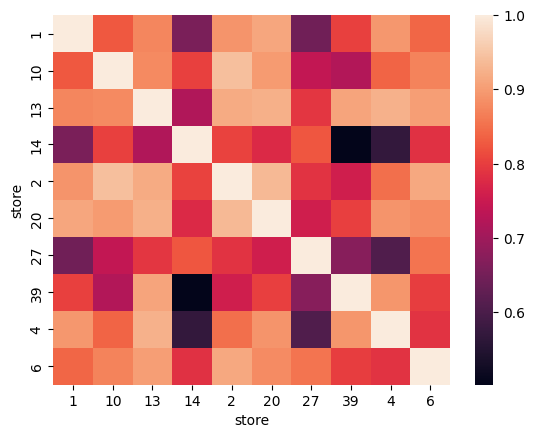

In [48]:
# get correlation between all store sales

df_sales_by_store = df_sales_top_stores.groupby(["store", "date"])["weekly_sales"].sum()


df_sales_by_store = df_sales_by_store.reset_index()

df_sales_by_store = df_sales_by_store.pivot(
    index="date", columns="store", values="weekly_sales"
)

df_sales_by_store = df_sales_by_store.fillna(0)


# heatmap
sns.heatmap(df_sales_by_store.corr())

df_sales_by_store.corr()

## FEATURES DATA

In [50]:
df_features.columns = df_features.columns.str.lower()

In [51]:
df_features["date"] = pd.to_datetime(df_features["date"])

In [56]:
def plot_feature(df, feature, agg="mean"):
    df_feature = df.groupby("date")[feature].agg(agg)
    df_feature.plot()
    plt.title(feature)
    plt.show()

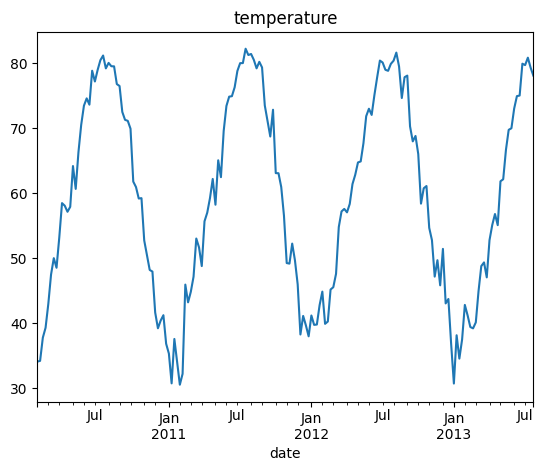

In [57]:
plot_feature(df_features, "temperature")

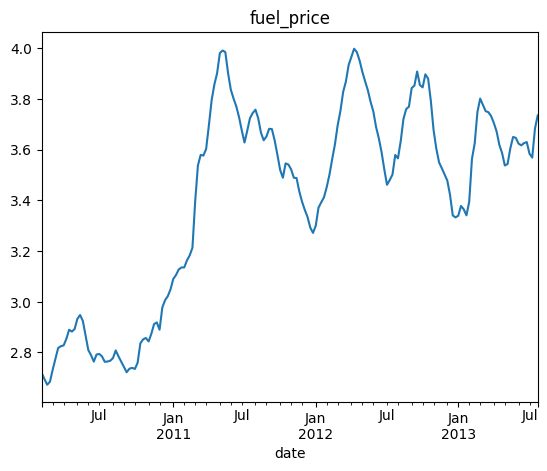

In [58]:
plot_feature(df_features, "fuel_price")

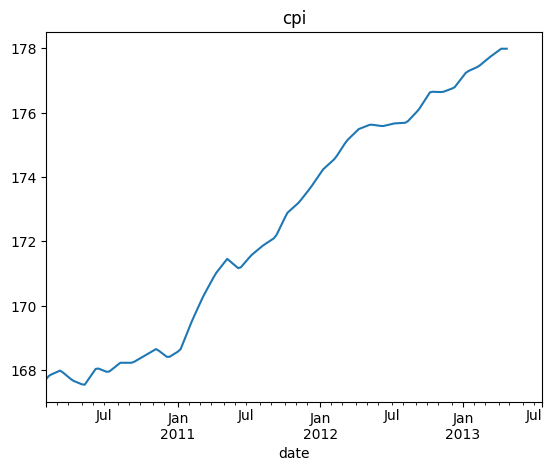

In [59]:
plot_feature(df_features, "cpi")

In [60]:
df_features.columns

Index(['store', 'date', 'temperature', 'fuel_price', 'markdown1', 'markdown2',
       'markdown3', 'markdown4', 'markdown5', 'cpi', 'unemployment',
       'isholiday'],
      dtype='object')

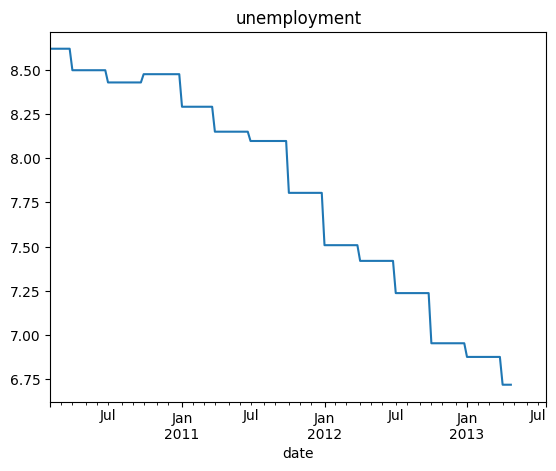

In [61]:
plot_feature(df_features, "unemployment")

## Multivariate analysis

In [71]:
df_train, df_test, df_features, df_stores = load_data()

In [72]:
df_train.columns = df_train.columns.str.lower()
df_test.columns = df_test.columns.str.lower()
df_features.columns = df_features.columns.str.lower()
df_stores.columns = df_stores.columns.str.lower()

In [74]:
df_features = df_features.merge(df_stores, on="store")

In [76]:
df_features.columns

Index(['store', 'date', 'temperature', 'fuel_price', 'markdown1', 'markdown2',
       'markdown3', 'markdown4', 'markdown5', 'cpi', 'unemployment',
       'isholiday', 'type', 'size'],
      dtype='object')

In [77]:
df_train = df_train.merge(df_features, on=["store", "date", "isholiday"])

In [78]:
df_train

,store,dept,date,weekly_sales,isholiday,temperature,fuel_price,markdown1,markdown2,markdown3,markdown4,markdown5,cpi,unemployment,type,size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013558,8.684,B,118221
421566,45,98,2012-10-05,628.10,False,64.89,3.985,5046.74,NaN,18.82,2253.43,2340.01,192.170412,8.667,B,118221
421567,45,98,2012-10-12,1061.02,False,54.47,4.000,1956.28,NaN,7.89,599.32,3990.54,192.327265,8.667,B,118221
421568,45,98,2012-10-19,760.01,False,56.47,3.969,2004.02,NaN,3.18,437.73,1537.49,192.330854,8.667,B,118221


In [1]:
# total sales by store and type
df_sales_by_store_type = df_train.groupby(["store", "type"])["weekly_sales"].sum()

df_sales_by_store_type = df_sales_by_store_type.reset_index().sort_values(
    ["type", "weekly_sales"], ascending=[True, False]
)

df_sales_by_store_type["store"] = df_sales_by_store_type["store"].astype("str")

sns.barplot(x="store", y="weekly_sales", hue="type", data=df_sales_by_store_type)

plt.xticks(rotation=45)

plt.show()

NameError: name 'df_train' is not defined

In [4]:
import pandas as pd
import numpy as np

df = pd.DataFrame(
    {
        "store_1": np.random.rand(100),
        "store_2": np.random.rand(100),
        "store_3": np.random.rand(100),
    }
)

df

,store_1,store_2,store_3
0,0.847948,0.036609,0.994962
1,0.343949,0.562869,0.469715
2,0.458250,0.507236,0.561331
3,0.541333,0.017716,0.527623
4,0.333442,0.578137,0.983746
...,...,...,...
95,0.081448,0.572913,0.015076
96,0.653863,0.677037,0.105301
97,0.888945,0.911774,0.104187
98,0.989289,0.304402,0.584178


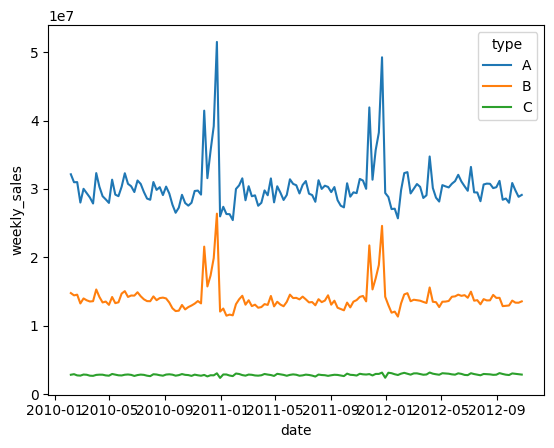

In [102]:
# plot time series by store type
df_sales_by_store_type = df_train.groupby(["type", "date"])["weekly_sales"].sum()

df_sales_by_store_type = df_sales_by_store_type.reset_index()


df_sales_by_store_type["date"] = pd.to_datetime(df_sales_by_store_type["date"])

sns.lineplot(x="date", y="weekly_sales", hue="type", data=df_sales_by_store_type)

min_date = df_sales_by_store_type["date"].min()
max_date = df_sales_by_store_type["date"].max()

# reduce frequency of xticks